In [1]:
import numpy as np
import pytesseract 
from PIL import Image, ImageDraw


In [2]:
def image_to_ocr_data(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    ocr_df = pytesseract.image_to_data(image, output_type='data.frame')        
    ocr_df = ocr_df.dropna().assign(x0 = ocr_df.left,
                        y0 = ocr_df.top,
                        x1 = lambda x: x.left + x.width,
                        y1 = lambda y: y.top + y.height,
                        image_width = width,
                        image_height = height
                        )

    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    ocr_df = ocr_df.drop(columns = ["left","top"])
    return ocr_df

In [3]:
image_path = "../data/raw/extract-scan.png"

In [4]:
img = Image.open(image_path).convert("RGB")

/home/myihbach/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
df = image_to_ocr_data(image_path)

In [6]:
df.head()

,level,page_num,block_num,par_num,line_num,word_num,width,height,conf,text,x0,y0,x1,y1,image_width,image_height
0,5,1,1,1,1,1,212,55,96,Chapter,356,129,568,184,955,1236
1,5,1,1,1,1,2,18,39,96,I,581,132,599,171,955,1236
2,5,1,2,1,1,1,86,15,96,“Treats,118,260,204,275,955,1236
3,5,1,2,1,1,2,22,16,96,of,213,259,235,275,955,1236
4,5,1,2,1,1,3,37,16,96,the,243,259,280,275,955,1236


In [7]:
def draw_bboxes(image,dataframe):
    drawing = ImageDraw.Draw(image)
    for x0,y0,x1,y1 in zip(dataframe["x0"] , dataframe["y0"], dataframe["x1"],dataframe["y1"]):
        drawing.rectangle([(x0,y0),(x1,y1)], outline ="red")
    return image.copy()

In [8]:
df.head()

,level,page_num,block_num,par_num,line_num,word_num,width,height,conf,text,x0,y0,x1,y1,image_width,image_height
0,5,1,1,1,1,1,212,55,96,Chapter,356,129,568,184,955,1236
1,5,1,1,1,1,2,18,39,96,I,581,132,599,171,955,1236
2,5,1,2,1,1,1,86,15,96,“Treats,118,260,204,275,955,1236
3,5,1,2,1,1,2,22,16,96,of,213,259,235,275,955,1236
4,5,1,2,1,1,3,37,16,96,the,243,259,280,275,955,1236


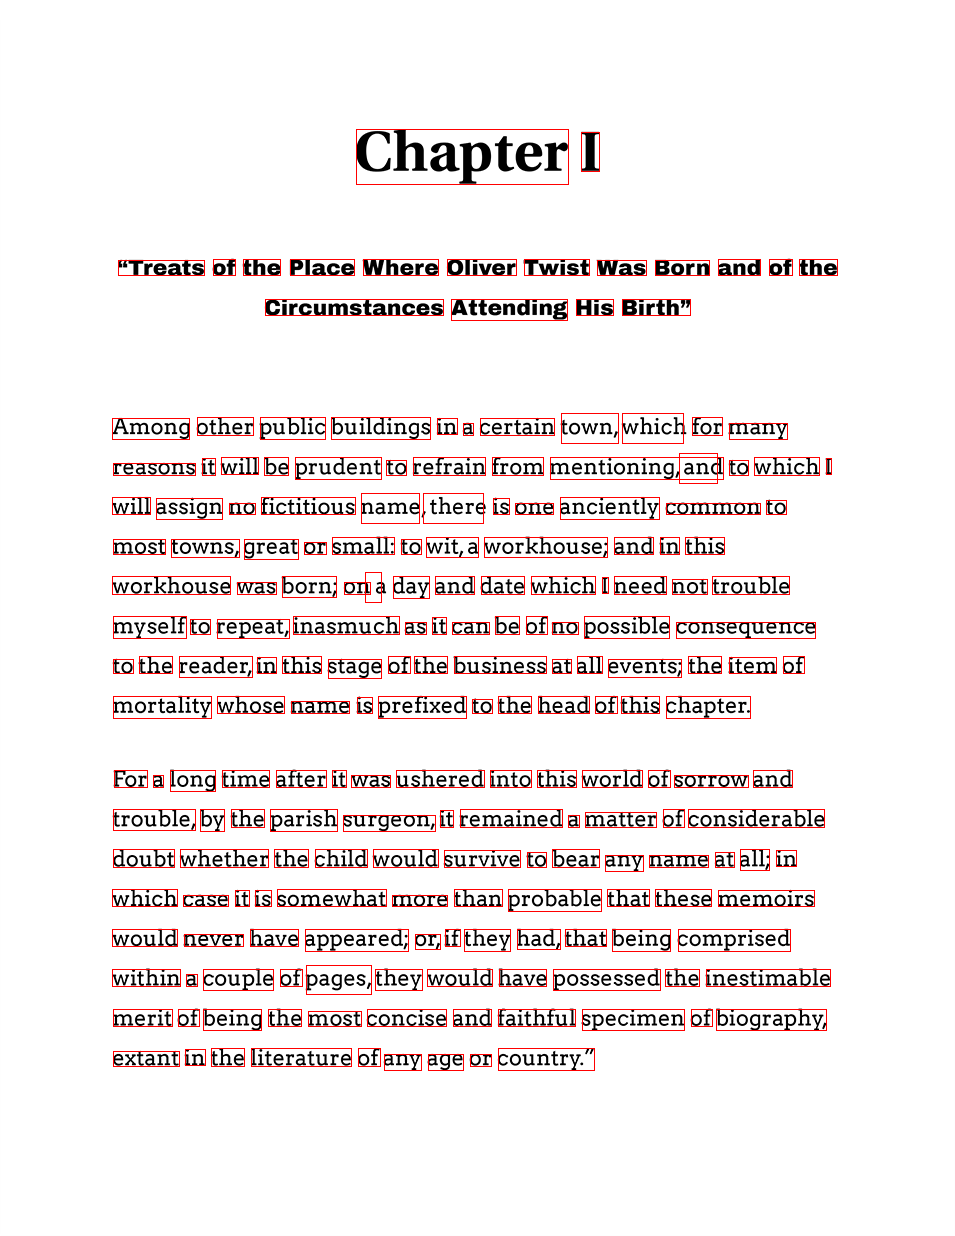

In [9]:
draw_bboxes(img,df)

In [10]:
import pybboxes as pbx

In [11]:
help(pbx.convert_bbox)

Help on function convert_bbox in module pybboxes.functional:

convert_bbox(bbox: Union[numpy.ndarray, Tuple[float, float, float, float], Tuple[int, int, int, int], Sequence[float], Sequence[int]], from_type: str = None, to_type: str = None, image_size: Tuple[int, int] = None, return_values: bool = True, **kwargs) -> Union[Tuple[float, float, float, float], Tuple[int, int, int, int], pybboxes.boxes.base.BaseBoundingBox]
    Converts given bbox with given `from_type` to given `to_type`. It uses VOC format
    as an intermediate format.
    
    Args:
        bbox: (generic) Bounding box.
        from_type: (str) Type/Format of the given bounding box.
        to_type: (str) Type/Format of the resulting bounding box.
        image_size: (tuple(int,int)) Image size as (w, h) tuple, it is required if the one side of the
            boxes requires scaling.
        return_values: (bool) Whether to return values as a Tuple, or BoundingBox object.
            True by default for compatibility pu

In [12]:

def create_annotations_of_image(annotation_df,file_name):
    file = open(f"{file_name}.txt", "w")
    annotation_list = []
    for x0,y0,width,height,w,h in zip(annotation_df["x0"] , annotation_df["y0"], annotation_df["width"],annotation_df["height"],annotation_df['image_width'],annotation_df['image_height']):
        yolo_annot = pbx.convert_bbox((x0,y0,width,height), from_type="coco", to_type="yolo", image_size=(w,h))
        annotation_list.append(f"{0} {yolo_annot[0]} {yolo_annot[1]} {yolo_annot[2]} {yolo_annot[3]}\n")
    file.writelines(annotation_list)
    file.close()

In [13]:
import os

In [14]:
create_annotations_of_image(df,os.path.splitext(image_path)[0])

In [120]:

# >>> (0.15, 0.15, 0.1, 0.1)